# Pretrained Model

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ayuraj/asl-dataset")

print("Path to dataset files:", path)

100%|██████████| 56.9M/56.9M [00:00<00:00, 83.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ayuraj/asl-dataset/versions/1


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Flatten, Dense,Dropout
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
%matplotlib inline

Dataset contents: ['2', 'h', 'd', 'u', '6', 'asl_dataset', 'z', 'f', 's', 'a', '8', 'j', '1', 't', 'i', 'n', '5', '9', '4', 'q', 'e', '7', 'x', 'l', 'o', 'm', 'c', 'g', '3', 'k', 'v', 'w', 'b', 'y', 'r', '0', 'p']
Total Images Found: 2515
                         img_names categories  \
0   hand1_2_dif_seg_5_cropped.jpeg          2   
1   hand2_2_dif_seg_2_cropped.jpeg          2   
2   hand2_2_bot_seg_4_cropped.jpeg          2   
3  hand2_2_left_seg_5_cropped.jpeg          2   
4   hand2_2_top_seg_5_cropped.jpeg          2   

                                           img_paths  
0  /root/.cache/kagglehub/datasets/ayuraj/asl-dat...  
1  /root/.cache/kagglehub/datasets/ayuraj/asl-dat...  
2  /root/.cache/kagglehub/datasets/ayuraj/asl-dat...  
3  /root/.cache/kagglehub/datasets/ayuraj/asl-dat...  
4  /root/.cache/kagglehub/datasets/ayuraj/asl-dat...  


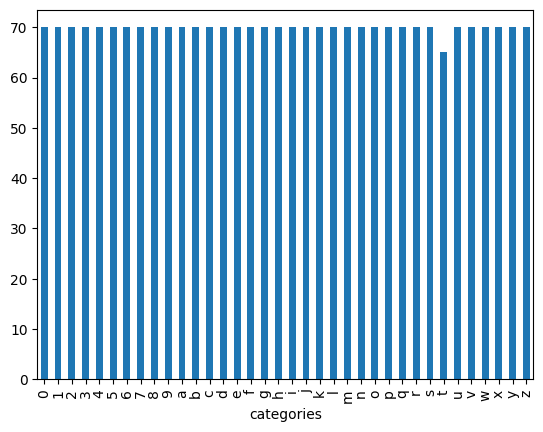

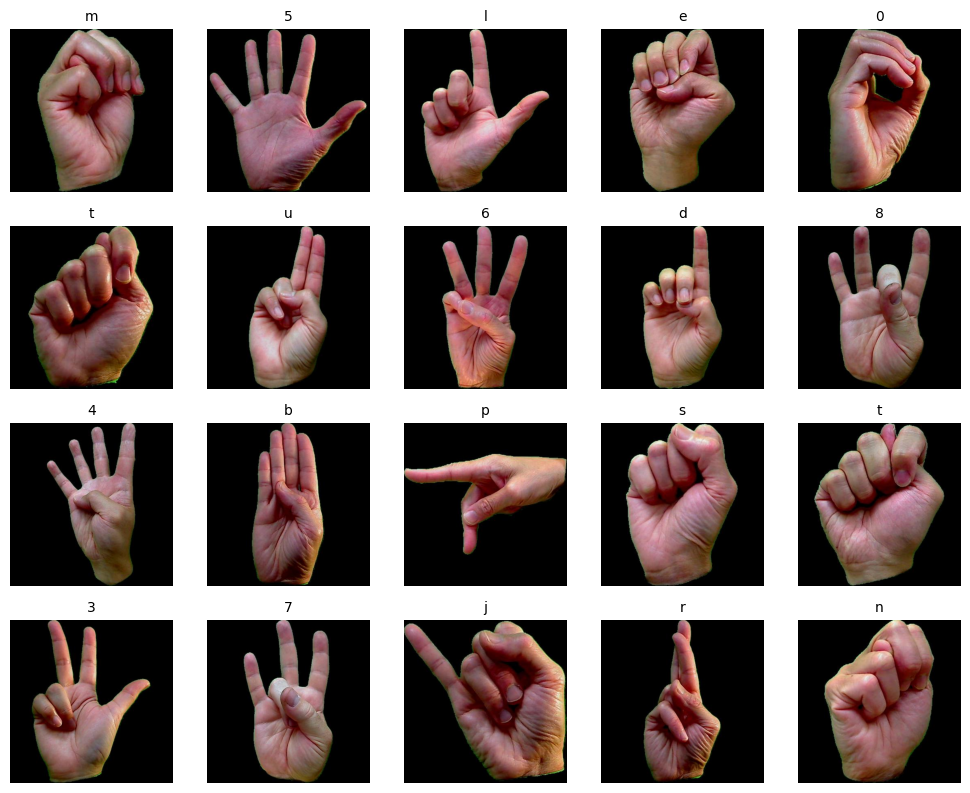

In [ ]:
# Get dataset root directory
dataset_path = os.path.join(path, "asl_dataset")  # Update this based on your dataset structure

# Verify dataset structure
print("Dataset contents:", os.listdir(dataset_path))

# Prepare DataFrame
img_df = pd.DataFrame(columns=["img_names", "categories", "img_paths"])
file_names = os.listdir(dataset_path)

# Remove system files
if ".DS_Store" in file_names:
    file_names.remove(".DS_Store")

# Collect image paths
img_list = []

for img_category in file_names:
    category_path = os.path.join(dataset_path, img_category)

    if os.path.isdir(category_path):  # Ensure it's a directory
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            if os.path.isfile(img_path):  # Only include image files
                img_list.append({"img_names": img_name, "categories": img_category, "img_paths": img_path})

# Convert to DataFrame
df = pd.DataFrame(img_list)

# Print DataFrame structure
print("Total Images Found:", df.shape[0])
print(df.head())
df["categories"].sort_values().value_counts(sort=False).plot(kind="bar");
# Plot example images
plt.figure(figsize=(10, 10))
for i in range(20):
    j = np.random.randint(df.shape[0])
    try:
        img = plt.imread(df["img_paths"].iloc[j])
        plt.subplot(5, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(df['categories'].iloc[j], fontsize=10)
    except Exception as e:
        print(f"Error loading image {df['img_paths'].iloc[j]}: {e}")

plt.tight_layout()
plt.show()


In [ ]:
X = df["img_paths"].values
Y = df["categories"]
lb = LabelEncoder()
Y_encode = lb.fit_transform(Y)
Y_encode = to_categorical(Y_encode)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_encode, test_size=0.25, random_state=42)
X_test, X_valid, Y_test, Y_valid = train_test_split(X_test, Y_test, test_size=.5, random_state=42)
X_train.shape, X_test.shape
input_h, input_w = 224, 224
x_test_arr = np.zeros((X_test.shape[0], input_h, input_w,  3))

for i in range(len(X_test)):

    im = load_img(X_test[i],
        color_mode="rgb",
        target_size=(input_h, input_w),
        interpolation="nearest",
        keep_aspect_ratio=False)
    x_test_arr[i] = img_to_array(im)/255

x_train_arr = np.zeros((X_train.shape[0], input_h, input_w,  3))

for i in range(len(X_train)):

    im = load_img(X_train[i],
        color_mode="rgb",
        target_size=(input_h, input_w),
        interpolation="nearest",
        keep_aspect_ratio=False)
    x_train_arr[i] = img_to_array(im)/255

x_valid_arr = np.zeros((X_valid.shape[0], input_h, input_w,  3))

for i in range(len(X_valid)):

    im = load_img(X_valid[i],
        color_mode="rgb",
        target_size=(input_h, input_w),
        interpolation="nearest",
        keep_aspect_ratio=False)
    x_valid_arr[i] = img_to_array(im)/255

x_train_arr.shape, x_test_arr.shape, x_valid_arr.shape
Y_valid.shape, Y_test.shape, Y_train.shape

((315, 36), (314, 36), (1886, 36))

In [ ]:
img_size = 224
batch_size = 64

# Define the dataset paths
train_path = os.path.join(dataset_path)  # Root contains labeled folders
valid_path = os.path.join(dataset_path)  # Same root structure

# Data generator for training
datagen_train = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    validation_split=0.2
)
train_generator = datagen_train.flow_from_directory(train_path,
                                                    target_size=(img_size, img_size),
                                                    color_mode='grayscale',
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    subset="training")  # Using training subset

# Data generator for validation
validation_generator = datagen_train.flow_from_directory(valid_path,
                                                    target_size=(img_size, img_size),
                                                    color_mode='grayscale',
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False,
                                                    subset="validation")  # Using validation subset


Found 4024 images belonging to 37 classes.
Found 1006 images belonging to 37 classes.


In [ ]:
# Get the number of classes dynamically
num_classes = train_generator.num_classes

model = Sequential()

# Conv Block 1
model.add(Conv2D(64, (3,3), padding='same', input_shape=(224,224,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Conv Block 2
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Conv Block 3
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

# Fully connected Block 1
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected Block 2
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# 🔹 Change number of classes dynamically
model.add(Dense(num_classes, activation='softmax'))

# Use learning_rate instead of lr
opt = Adam(learning_rate=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 224, 224, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 128)       │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 512)         │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 56, 56, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28, 28, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 401408)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │     102,760,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 103,713,061 (395.63 MB)

 Trainable params: 103,710,117 (395.62 MB)

 Non-trainable params: 2,944 (11.50 KB)

Epoch 1/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.4871 - loss: 2.0243
Epoch 1: val_accuracy improved from -inf to 0.68229, saving model to weights-improvement.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 50s 862ms/step - accuracy: 0.4872 - loss: 2.0239 - val_accuracy: 0.6823 - val_loss: 2.3904 - learning_rate: 1.0000e-06
Epoch 2/60
 5/58 ━━━━━━━━━━━━━━━━━━━━ 16s 305ms/step - accuracy: 0.5590 - loss: 1.7900
Epoch 2: val_accuracy did not improve from 0.68229
58/58 ━━━━━━━━━━━━━━━━━━━━ 19s 319ms/step - accuracy: 0.5451 - loss: 1.8413 - val_accuracy: 0.6597 - val_loss: 2.3932 - learning_rate: 1.0000e-06
Epoch 3/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.5009 - loss: 1.9494
Epoch 3: val_accuracy did not improve from 0.68229
58/58 ━━━━━━━━━━━━━━━━━━━━ 27s 464ms/step - accuracy: 0.5008 - loss: 1.9499 - val_accuracy: 0.5590 - val_loss: 2.4900 - learning_rate: 1.0000e-06
Epoch 4/60
 5/58 ━━━━━━━━━━━━━━━━━━━━ 18s 349ms/step - accuracy: 0.5287 - loss: 1.9758
Epoch 4: val_accura

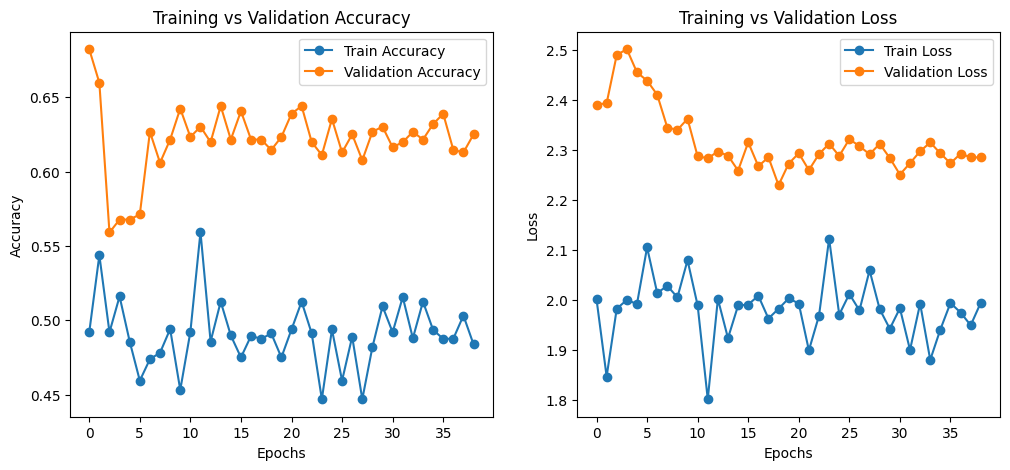

In [ ]:
# Learning rate scheduler
lr = ReduceLROnPlateau(monitor='val_accuracy',
                       patience=2,
                       factor=0.5,
                       verbose=1,
                       min_lr=1e-6)  # Ensures LR doesn’t go too low

# Early stopping to prevent overfitting
es = EarlyStopping(monitor='val_loss',
                   min_delta=0.00001,
                   patience=20,
                   restore_best_weights=True,
                   verbose=1)  # Enabled verbosity

# Model checkpoint to save best model based on validation accuracy
checkpoint = ModelCheckpoint("weights-improvement.keras",
                             monitor="val_accuracy",
                             verbose=1,
                             save_best_only=True,
                             mode="max")

# 🔹 Combine all callbacks
callbacks_list = [checkpoint, lr, es]

# Training parameters
epochs = 60
batch_size = 32

# 🔹 Ensure dataset variables match
history = model.fit(train_generator,
                    steps_per_epoch=x_train_arr.shape[0] // batch_size,
                    validation_data=validation_generator,
                    validation_steps=x_valid_arr.shape[0] // batch_size,
                    epochs=epochs,
                    callbacks=callbacks_list)

# Convert history to DataFrame for easy visualization
hist_ = pd.DataFrame(history.history)

# 🔹 Display training curves
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(hist_["accuracy"], label="Train Accuracy", marker="o")
plt.plot(hist_["val_accuracy"], label="Validation Accuracy", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(hist_["loss"], label="Train Loss", marker="o")
plt.plot(hist_["val_loss"], label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.show()


**Task 2: Model Implementation and Fine-tuning**

**Instructions:**

1. Implement the pre-trained model as described in the research paper.

2. Visualize feature maps of few layers

3. Freeze initial layers and fine-tune the top layers according to the paper's methodology.

4. Optimize hyperparameters such as:

  Learning rate

  Batch size

  Number of epochs

  Optimizer choice (Adam, SGD, RMSprop, etc.)

4. Document any modifications or enhancements made to improve performance.

# VGG 16

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0


Found 4024 images belonging to 37 classes.
Found 1006 images belonging to 37 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 109s 718ms/step - accuracy: 0.0837 - loss: 4.2573 - val_accuracy: 0.0129 - val_loss: 8.9709
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 67s 535ms/step - accuracy: 0.1951 - loss: 3.2280 - val_accuracy: 0.3032 - val_loss: 4.4162
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 68s 542ms/step - accuracy: 0.3088 - loss: 2.5717 - val_accuracy: 0.0616 - val_loss: 12.1793
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 67s 532ms/step - accuracy: 0.3852 - loss: 2.3125 - val_accuracy: 0.0994 - val_loss: 6.7157
Epoch 5/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 68s 543ms/step - accuracy: 0.4055 - loss: 2.1044 - val_accuracy: 0.3350 - val_loss: 4.2751
Epoch 6/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 67s 535ms/step - accuracy: 0.4543 - loss: 1.7698 - val_accuracy: 0.0785 - val_loss: 4.6861
Epoch 7/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 68s 541ms/step - accuracy: 0.4512 -

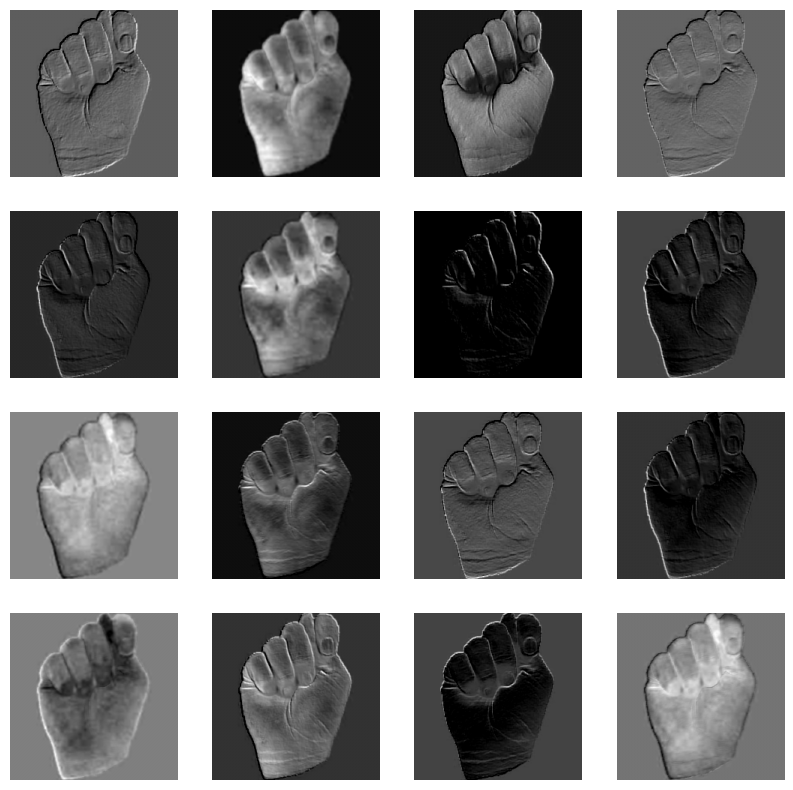

In [ ]:


train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),  # Resize images here
    batch_size=32,
    class_mode="categorical",
    subset="training")

validation_generator = train_datagen.flow_from_directory(
    valid_path,
    target_size=(224, 224),  # Resize images here
    batch_size=32,
    class_mode="categorical",
    subset="validation")

# Load VGG16 model (excluding the top layers)
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))


# Freeze initial layers
for layer in base_model.layers[:15]:
    layer.trainable = False

# Add custom classifier
x = Flatten()(base_model.output)
x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(512, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation="softmax")(x)

model_vgg16 = Model(inputs=base_model.input, outputs=output)

# Compile model
model_vgg16.compile(optimizer=Adam(learning_rate=0.0003), loss="categorical_crossentropy", metrics=["accuracy"])

# Train model
history_vgg16 = model_vgg16.fit(train_generator,
                                validation_data=validation_generator,
                                epochs=10,
                                batch_size=32,
                                verbose=1)

# Feature Map Visualization
layer_outputs = [layer.output for layer in base_model.layers if 'conv' in layer.name]
feature_map_model = Model(inputs=base_model.input, outputs=layer_outputs)

# Load a random image from validation set
img = np.expand_dims(x_valid_arr[0], axis=0)
feature_maps = feature_map_model.predict(img)

# Plot feature maps of first conv layer
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(feature_maps[0][0, :, :, i], cmap="gray")
    ax.axis("off")
plt.show()


# ResNet 50

Epoch 1/8
126/126 ━━━━━━━━━━━━━━━━━━━━ 117s 683ms/step - accuracy: 0.1432 - loss: 4.0430 - val_accuracy: 0.5000 - val_loss: 7710.3301
Epoch 2/8
126/126 ━━━━━━━━━━━━━━━━━━━━ 65s 513ms/step - accuracy: 0.4318 - loss: 2.9296 - val_accuracy: 0.0139 - val_loss: 9.0416
Epoch 3/8
126/126 ━━━━━━━━━━━━━━━━━━━━ 64s 508ms/step - accuracy: 0.4714 - loss: 2.8149 - val_accuracy: 0.5000 - val_loss: 3.4000
Epoch 4/8
126/126 ━━━━━━━━━━━━━━━━━━━━ 74s 588ms/step - accuracy: 0.4614 - loss: 2.7503 - val_accuracy: 0.0139 - val_loss: 23.8811
Epoch 5/8
126/126 ━━━━━━━━━━━━━━━━━━━━ 72s 574ms/step - accuracy: 0.4589 - loss: 2.6208 - val_accuracy: 0.0278 - val_loss: 6.0749
Epoch 6/8
126/126 ━━━━━━━━━━━━━━━━━━━━ 72s 573ms/step - accuracy: 0.4866 - loss: 2.4282 - val_accuracy: 0.5000 - val_loss: 10.8298
Epoch 7/8
126/126 ━━━━━━━━━━━━━━━━━━━━ 64s 509ms/step - accuracy: 0.4699 - loss: 2.4045 - val_accuracy: 0.0219 - val_loss: 9.8751
Epoch 8/8
126/126 ━━━━━━━━━━━━━━━━━━━━ 65s 517ms/step - accuracy: 0.4639 - loss: 2.3

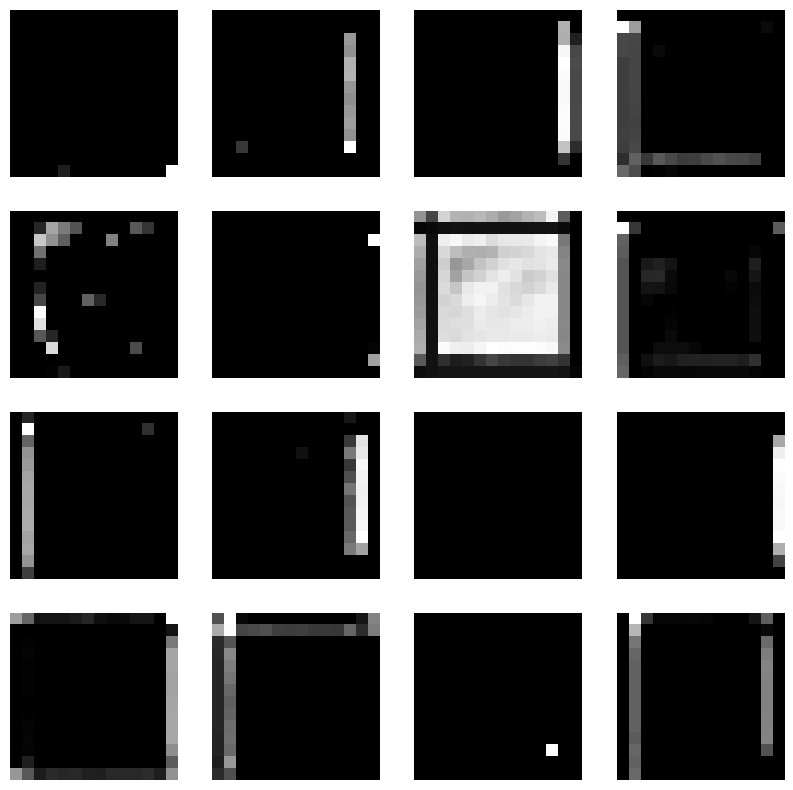

In [ ]:

# Load ResNet50 without top layers
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze first 100 layers
for layer in base_model.layers[:100]:
    layer.trainable = False

# Add classifier
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation="softmax")(x)

model_resnet50 = Model(inputs=base_model.input, outputs=output)

# Compile model
model_resnet50.compile(optimizer="RMSprop", loss="categorical_crossentropy", metrics=["accuracy"])

# Train model
history_resnet50 = model_resnet50.fit(train_generator,
                                      validation_data=validation_generator,
                                      epochs=8,
                                      batch_size=32,
                                      verbose=1)

# Feature Map Visualization
layer_outputs = [base_model.get_layer("conv4_block3_out").output]  # Example layer

feature_map_model = Model(inputs=base_model.input, outputs=layer_outputs)

# Load a random image from validation set
img = np.expand_dims(x_valid_arr[0], axis=0)
feature_maps = feature_map_model.predict(img)

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(feature_maps[0, :, :,i], cmap="gray")
    ax.axis("off")
plt.show()


# EfficientNetB0

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 93s 905ms/step - accuracy: 0.0339 - loss: 4.2531 - val_accuracy: 0.5000 - val_loss: 3.1285
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 26s 414ms/step - accuracy: 0.1472 - loss: 3.3644 - val_accuracy: 0.5000 - val_loss: 2.6485
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 437ms/step - accuracy: 0.3045 - loss: 2.7273 - val_accuracy: 0.5000 - val_loss: 2.5435
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 422ms/step - accuracy: 0.3741 - loss: 2.3120 - val_accuracy: 0.5000 - val_loss: 2.7437
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 421ms/step - accuracy: 0.4403 - loss: 1.9995 - val_accuracy: 0.5000 - val_loss: 2.9222
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 424ms/step - accuracy: 0.4591 - loss: 1.8242 - val_accuracy: 0.4990 - val_loss: 2.5487
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 423ms/step - accuracy: 0.4772 - loss: 1.6527 - val_accuracy: 0.3151 - val_loss: 2.8472
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 429ms/step - accuracy: 0.4733 - loss: 1.5666 - val_accu

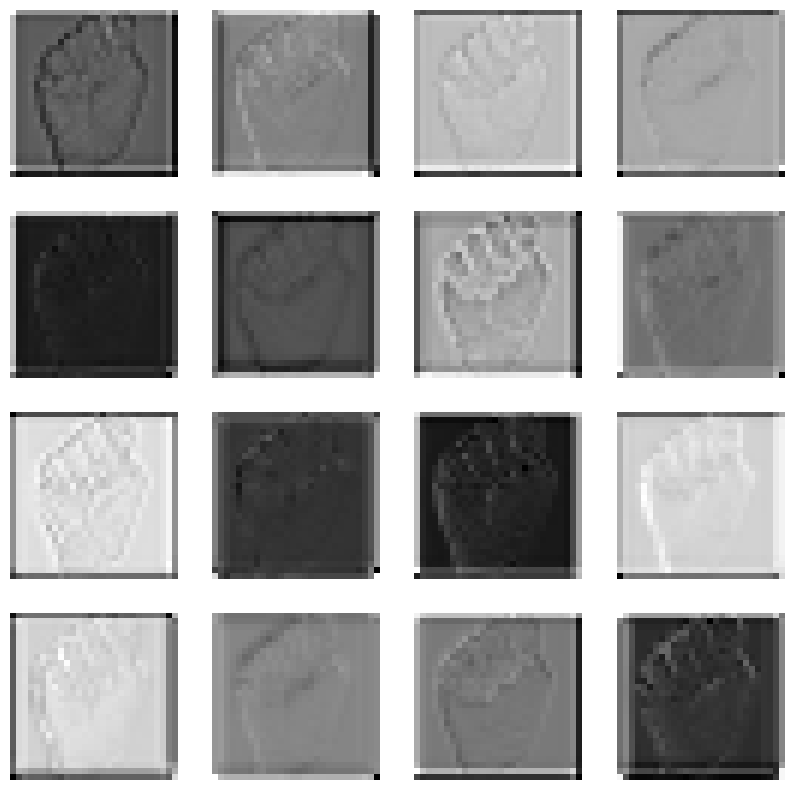

In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input

# Load EfficientNetB0 without top layers
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze initial layers
for layer in base_model.layers[:50]:
    layer.trainable = False

# Add custom classifier
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
output = Dense(num_classes, activation="softmax")(x)

model_efficientnet = Model(inputs=base_model.input, outputs=output)

# Compile model
model_efficientnet.compile(optimizer="SGD", loss="categorical_crossentropy", metrics=["accuracy"])

# Train model
history_efficientnet = model_efficientnet.fit(train_generator,
                                              validation_data=validation_generator,
                                              epochs=10,
                                              batch_size=32,
                                              verbose=1)

# Feature Map Visualization
#layer_outputs = [base_model.get_layer("conv4_block3_out").output]  # Example layer
# Choose a valid layer for visualization
layer_name = "block3b_add"  # Change to an existing convolutional layer
selected_layer = base_model.get_layer(layer_name).output

# Create a model to extract feature maps
feature_map_model = Model(inputs=base_model.input, outputs=selected_layer)

# Load and preprocess a random validation image
img = np.expand_dims(x_valid_arr[0], axis=0)
img = preprocess_input(img)  # Ensure proper scaling for EfficientNetB0

# Get feature maps
feature_maps = feature_map_model.predict(img)

# Reshape and visualize feature maps
selected_feature_map = np.squeeze(feature_maps, axis=0)  # Remove batch dimension
num_feature_maps = selected_feature_map.shape[-1]  # Number of feature maps

# Plot at most 16 feature maps
num_plots = min(num_feature_maps, 16)

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat[:num_plots]):
    ax.imshow(selected_feature_map[:, :, i], cmap="gray")
    ax.axis("off")
plt.show()



**Task 3: Model Evaluation and Performance Comparison**

**Instructions:**

1. Evaluate the trained model using performance metrics:

 Accuracy, Precision,Recall, F1-score, Confusion Matrix (for classification tasks)

2. Compare the results with those reported in the research paper.

3. Identify potential weaknesses and suggest improvements.
**Deliverables:**

Performance metrics summary (table or chart).

Graphs/plots showcasing model accuracy and loss trends.

Comparison with research paper results.

Discussion on model performance and areas for improvement.

**Conclusion and Result Visulaization**

**Declaration**

I, Suryansh Ambekar, confirm that the work submitted in this assignment is my own and has been completed following academic integrity guidelines. The code is uploaded on my GitHub repository account, and the repository link is provided below:

GitHub Repository Link: https://github.com/Suryanshambekar?tab=repositories

Signature: Suryansh Sanket Ambekar

**Submission Checklist**

✔ Research paper details and summary

✔ Code file (Python Notebook or Script)

✔ Dataset or link to the dataset

✔ Visualizations (if applicable)

✔ Screenshots of model performance metrics

✔ Readme File

✔ Comparison with research paper results